# Sentiment of Analysis of Tweets

---

## 1. Pre-Processing the text

### Import required libraries

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim.downloader as api

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout

from sklearn.metrics import classification_report

### Read Dataset

In [2]:
df = pd.read_csv('sentiment140.csv')
df.head()

,text,date,user,sentiment,query
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY
1,is upset that he can't update his Facebook by ...,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY
2,@Kenichan I dived many times for the ball. Man...,Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY
3,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY
4,"@nationwideclass no, it's not behaving at all....",Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY


### Check Label Count

In [3]:
print(df['sentiment'].value_counts())

sentiment
0    800000
4    800000
Name: count, dtype: int64


### Label Conversion

In [4]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 4 else 0)

print(set(df['sentiment']))

{0, 1}


### Pre-process text

In [5]:
def preprocess_text(text):
    text = re.sub(r'http\S+', 'URL', text)
    text = re.sub(r'@\w+', 'MENTION', text)
    text = re.sub(r'#\w+', 'HASHTAG', text)

    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].apply(preprocess_text)
df.head()

,text,date,user,sentiment,query
0,MENTION URL Awww thats a bummer You shoulda ...,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY
1,is upset that he cant update his Facebook by t...,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY
2,MENTION I dived many times for the ball Manage...,Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY
3,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY
4,MENTION no its not behaving at all im mad why ...,Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY


### Tokenization and Lemmatization

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

df['text'] = df['text'].apply(tokenize_and_lemmatize)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,date,user,sentiment,query
0,"[MENTION, URL, Awww, thats, a, bummer, You, sh...",Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,0,NO_QUERY
1,"[is, upset, that, he, cant, update, his, Faceb...",Mon Apr 06 22:19:49 PDT 2009,scotthamilton,0,NO_QUERY
2,"[MENTION, I, dived, many, time, for, the, ball...",Mon Apr 06 22:19:53 PDT 2009,mattycus,0,NO_QUERY
3,"[my, whole, body, feel, itchy, and, like, it, ...",Mon Apr 06 22:19:57 PDT 2009,ElleCTF,0,NO_QUERY
4,"[MENTION, no, it, not, behaving, at, all, im, ...",Mon Apr 06 22:19:57 PDT 2009,Karoli,0,NO_QUERY


### Print first 20 tweets

In [7]:
# print(df['text'].head(20))

for i in range(20):
    print(i, df['text'][i])

0 ['MENTION', 'URL', 'Awww', 'thats', 'a', 'bummer', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', 'D']
1 ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'Facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'a', 'a', 'result', 'School', 'today', 'also', 'Blah']
2 ['MENTION', 'I', 'dived', 'many', 'time', 'for', 'the', 'ball', 'Managed', 'to', 'save', '50', 'The', 'rest', 'go', 'out', 'of', 'bound']
3 ['my', 'whole', 'body', 'feel', 'itchy', 'and', 'like', 'it', 'on', 'fire']
4 ['MENTION', 'no', 'it', 'not', 'behaving', 'at', 'all', 'im', 'mad', 'why', 'am', 'i', 'here', 'because', 'I', 'cant', 'see', 'you', 'all', 'over', 'there']
5 ['MENTION', 'not', 'the', 'whole', 'crew']
6 ['Need', 'a', 'hug']
7 ['MENTION', 'hey', 'long', 'time', 'no', 'see', 'Yes', 'Rains', 'a', 'bit', 'only', 'a', 'bit', 'LOL', 'Im', 'fine', 'thanks', 'hows', 'you']
8 ['MENTION', 'nope', 'they', 'didnt', 'have', 'it']
9 ['MENTION', 'que', 'me', 'muera']
10 ['spring'

### Train Test Split
- 70% Train
- 15% Validation
- 15% Test

In [8]:
X = df['text']
y = df['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
print('Train Set Size', len(y_train))
print('Validation Set Size', len(y_val))
print('Test Set Size', len(y_test))

Train Set Size 1120000
Validation Set Size 240000
Test Set Size 240000


---

## 2. Vectorization and Padding

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max([len(seq) for seq in X_train_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

---

## 3. Word Embedding

In [10]:
w2v_model = api.load('word2vec-google-news-300')

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


---

## 4. RNN Model

### Create Model
In the questions setup, we were instructed to use a `Linear` activation function with `Binary Crossentropy` as the loss in the final layer. However, this configuration led to an unstable training process. After switching the activation function to `Sigmoid`, the training process became more stable and achieved a high level of accuracy and F1 score.

A `linear` activation function can produce output values beyond the `[0, 1] range`, which is not suitable for probability interpretation. When combined with `binary cross-entropy` loss, the optimization process becomes unstable because the predicted values can be arbitrarily large or small, leading to extremely large gradients and unstable updates. For `linear` activation function we might get better results using `Mean Squared Error` loss.

In [11]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 300)           103385700 
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 103605477 (395.22 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 103385700 (394.39 MB)
_________________________________________________________________


### Training Model
- Final Layer Activation Function: Sigmoid
- Loss: Binary Cross Entropy

In [12]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=512, validation_data=(X_val_padded, y_val))

Epoch 1/5
2188/2188 [==============================] - 49s 20ms/step - loss: 0.4659 - accuracy: 0.7782 - val_loss: 0.4325 - val_accuracy: 0.8010
Epoch 2/5
2188/2188 [==============================] - 41s 19ms/step - loss: 0.4211 - accuracy: 0.8062 - val_loss: 0.4139 - val_accuracy: 0.8105
Epoch 3/5
2188/2188 [==============================] - 44s 20ms/step - loss: 0.4047 - accuracy: 0.8149 - val_loss: 0.4061 - val_accuracy: 0.8168
Epoch 4/5
2188/2188 [==============================] - 47s 21ms/step - loss: 0.3935 - accuracy: 0.8212 - val_loss: 0.3989 - val_accuracy: 0.8198
Epoch 5/5
2188/2188 [==============================] - 40s 18ms/step - loss: 0.3847 - accuracy: 0.8260 - val_loss: 0.3913 - val_accuracy: 0.8220


### Plot Trainig Progress

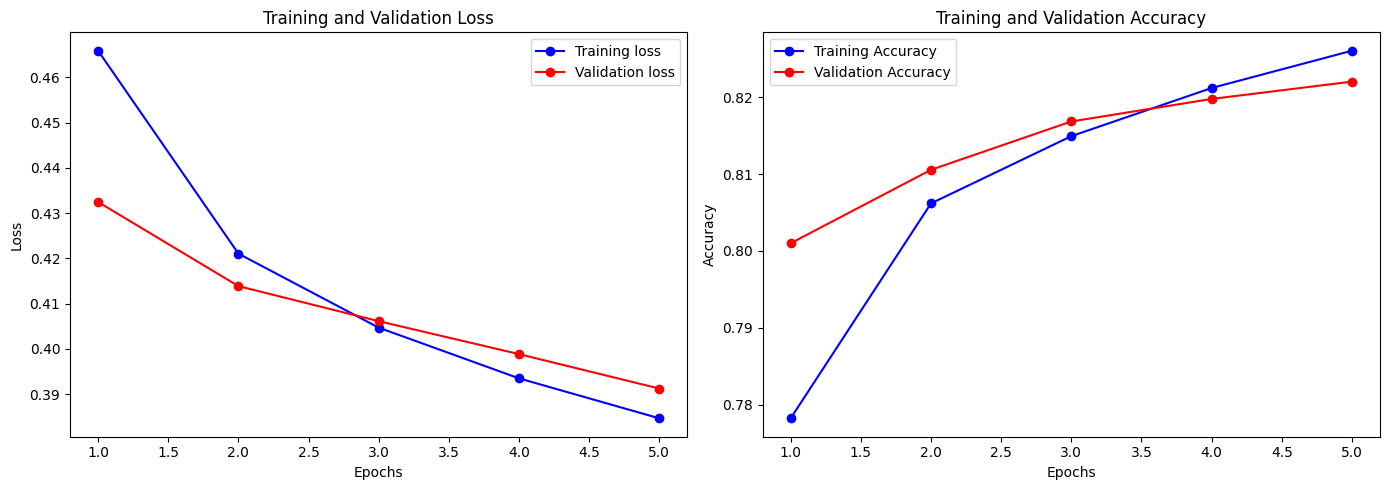

In [13]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [14]:
y_pred = (model.predict(X_test_padded) > 0.5).astype("int64")
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], zero_division=1)
print(report)

7500/7500 [==============================] - 21s 3ms/step
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.83    119907
    Positive       0.83      0.81      0.82    120093

    accuracy                           0.82    240000
   macro avg       0.82      0.82      0.82    240000
weighted avg       0.82      0.82      0.82    240000

